# Определение возраста покупателей

**ТЗ**

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


**Инструкция по выполнению проекта**

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите свёрточную нейронную сеть и рассчитайте её качество.
- Метрикой качества будет MAE меньше 7

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

import warnings

In [2]:
sns.set_style('whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

**В таблице указаны соответствия между названием изображения и возрастом человека на нём**

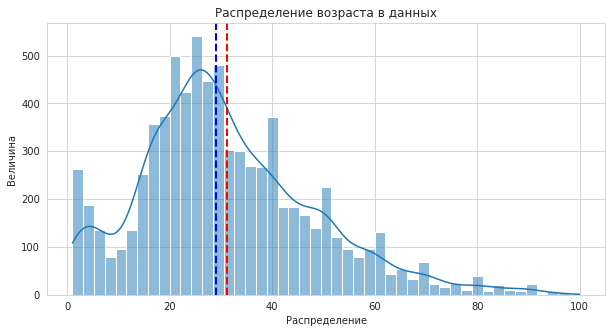

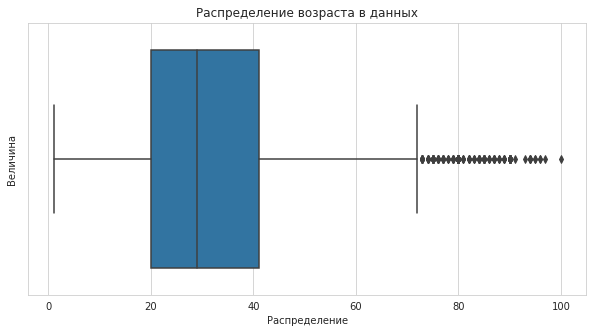

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(labels['real_age'], kde=True)

mean_age = labels['real_age'].mean()
median_age = labels['real_age'].median()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_age:.2f}')
plt.axvline(median_age, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median_age:.2f}')

plt.ylabel('Величина')
plt.xlabel('Распределение')
plt.title('Распределение возраста в данных')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(labels['real_age'])
plt.ylabel('Величина')
plt.xlabel('Распределение')
plt.title('Распределение возраста в данных')
plt.show()

In [7]:
labels['real_age'].min()

1

In [8]:
labels['real_age'].max()

100

In [9]:
labels['real_age'].loc[labels['real_age'] < 15].value_counts().sort_values(ascending=False)

1     149
14    125
4     101
2      88
5      87
13     79
6      68
7      67
12     56
11     51
10     45
8      44
9      34
3      25
Name: real_age, dtype: int64

In [10]:
labels['real_age'].loc[labels['real_age'] > 85].value_counts().sort_values(ascending=False)

90     21
87      6
94      5
89      4
86      3
88      3
95      2
96      2
91      1
93      1
97      1
100     1
Name: real_age, dtype: int64

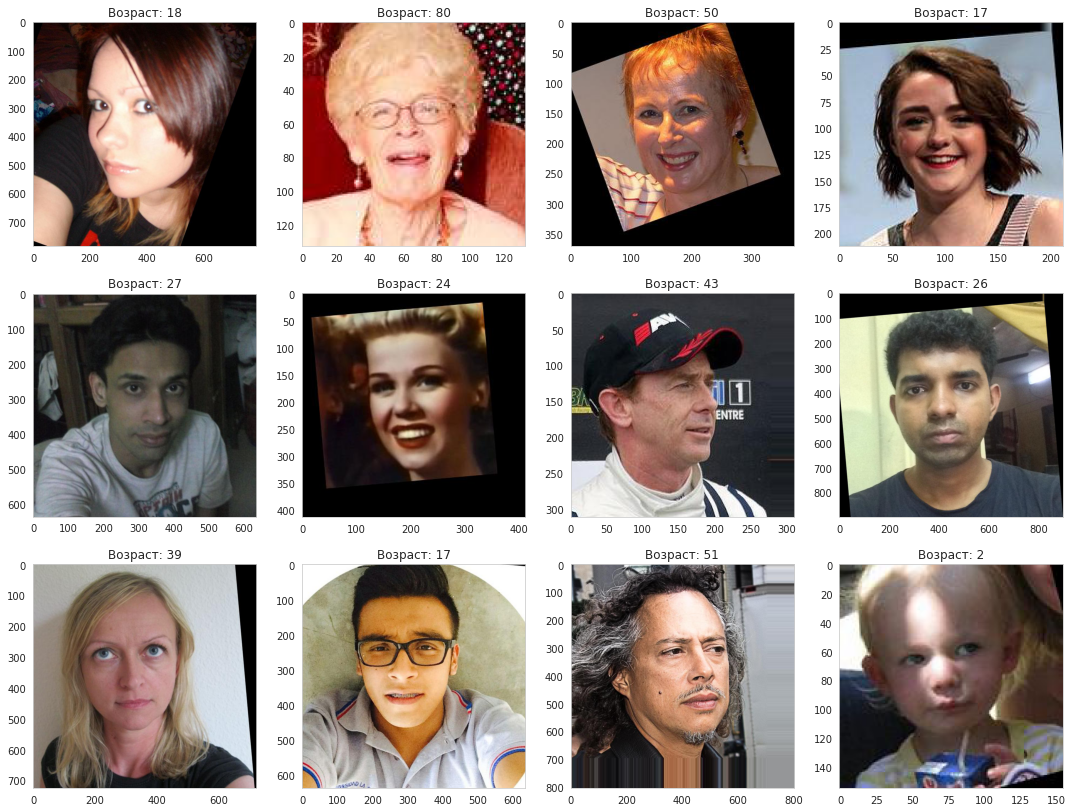

In [11]:
fig = plt.figure(figsize=(15, 15))

for i in range(1, 13):
    fig.add_subplot(4, 4, i)
    image_path = '/datasets/faces/final_files/' + labels.loc[i, 'file_name']
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.grid(False)
    plt.tight_layout()
    plt.title(f'Возраст: {labels.loc[i]["real_age"]}')

**Вывод**

- Данные представляют собой набор фотографий и таблицу с названиями изображений и соответствующему возрасту человека на каждом файле
- Всего нам представлено 7591 изображение
- В выборке встречаются экстремальные начения как очень молодых, так и очень старых людей, однако, их не так много в сравнение с другими возрастами
- Были выведены 12 изображений как пример данных

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        seed=2007,
        class_mode='raw',
        subset='training'
    )
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        seed=2007,
        class_mode='raw',
        subset='validation'
    )
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size, 
                epochs=15, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model


```

```

Epoch 1/15
356/356 - 71s - loss: 194.0590 - mae: 10.2146 - val_loss: 549.0305 - val_mae: 18.4070
Epoch 2/15
356/356 - 40s - loss: 68.7220 - mae: 6.3435 - val_loss: 123.7823 - val_mae: 8.5263
Epoch 3/15
356/356 - 39s - loss: 37.7234 - mae: 4.7571 - val_loss: 119.1825 - val_mae: 8.5730
Epoch 4/15
356/356 - 39s - loss: 23.7718 - mae: 3.7788 - val_loss: 76.0473 - val_mae: 6.4136
Epoch 5/15
356/356 - 39s - loss: 16.2657 - mae: 3.1262 - val_loss: 73.7300 - val_mae: 6.6563
Epoch 6/15
356/356 - 39s - loss: 13.2119 - mae: 2.7759 - val_loss: 67.8974 - val_mae: 6.2963
Epoch 7/15
356/356 - 39s - loss: 10.9341 - mae: 2.5454 - val_loss: 73.2321 - val_mae: 6.3580
Epoch 8/15
356/356 - 39s - loss: 11.1603 - mae: 2.5035 - val_loss: 77.1048 - val_mae: 6.7417
Epoch 9/15
356/356 - 39s - loss: 10.8880 - mae: 2.4625 - val_loss: 70.1172 - val_mae: 6.3087
Epoch 10/15
356/356 - 39s - loss: 10.7957 - mae: 2.4694 - val_loss: 101.6798 - val_mae: 7.7029
Epoch 11/15
356/356 - 39s - loss: 10.8920 - mae: 2.5019 - val_loss: 68.5798 - val_mae: 6.3175
Epoch 12/15
356/356 - 39s - loss: 10.3640 - mae: 2.4423 - val_loss: 69.6834 - val_mae: 6.4321
Epoch 13/15
356/356 - 39s - loss: 8.6080 - mae: 2.2276 - val_loss: 75.7723 - val_mae: 6.5710
Epoch 14/15
356/356 - 39s - loss: 8.0619 - mae: 2.1121 - val_loss: 65.7930 - val_mae: 6.1315
Epoch 15/15
356/356 - 39s - loss: 7.6210 - mae: 2.0674 - val_loss: 73.9918 - val_mae: 6.7188
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 73.9918 - mae: 6.7188
Test MAE: 6.7188

```

## Анализ обученной модели

**Вывод**

- Итоговой моделью для определения возраста по фотографии была выбрана свёрточная нейронная сеть, основанная на архитектуре ResNet
- Модель написана на основе шаблона из тренажёра, (разбита на функции, отвечающие за сбор данных, создание модели и её обучение)
- Величина Adam(learning_rate=0.0001) была установлена путём подбора различных величин
- Функцией потерь в моделе указана MSE, метрикой качества – MAE
- Для обучения модели было выбрано 15 поколений, однако, опираясь на полученные данные, количество эпох можно уменьшить до 5-9
- Получившаячя модель (с актуальными параметрами настройки) показывает метрику 6.7, в то время как по ТЗ метрика должна быть меньше 8. Следовательно, модель соответствует условиям ТЗ.